<a href="https://colab.research.google.com/github/phoenixfin/deeplearning-notebooks/blob/main/BBC_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document Classification

---

Aditya Firman Ihsan

## Persiapan

### Import library

In [ ]:
import tensorflow as tf
import numpy as np
import os, random
from google.colab import drive
from matplotlib import pyplot as plt

In [ ]:
tf.__version__

'2.3.0'

### Mengunduh dataset


Menginstall modul terbaru yang akan dipakai untuk mengunduh dataset dari [Kaggle](https://kaggle.com)

In [ ]:
%%capture
!pip install kaggle --upgrade

Muat isi Google Drive untuk mengakses file json dari API Kaggle. File ini dibutuhkan untuk mengakses langsung dataset dari Kaggle. Pastikan anda sudah membuat token pribadi anda sendiri di website Kaggle (buka bagian *My Account* di halaman profil, kemudian klik *Create New Api Token*) dan menaruhnya di Google Drive.

Cukup *uncomment* blok kode di bawah, jalankan, ikuti pranala yang diberikan, beri akses oleh akun Google yang anda miliki, dan salin kode verifikasi yang diberikan.

Alternatifnya, anda cukup klik ikon *Mount Drive* di *Files pane* di sisi kiri jendela colab ini.


In [ ]:
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Blok kode berikut untuk memastikan modul kaggle akan membaca token yang telah anda siapkan.

Isikan variabel `json_path` dengan *path* dari file json API yang anda telah taruh di Google Drive.

In [ ]:
json_path = "Colab Notebooks/misc/"

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/"+json_path

Unduh dataset yang akan digunakan. Dalam notebook ini, akan digunakan data teks Dokumen BBC yang berisi 2225 file `.txt` yang telah dikelompokkan dalam 5 kelas berbeda.

Info selengkapnya mengenai dataset ini bisa lihat [di sini](https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification)

In [ ]:
!kaggle datasets download -d shivamkushwaha/bbc-full-text-document-classification

  0% 0.00/5.59M [00:00<?, ?B/s]
100% 5.59M/5.59M [00:00<00:00, 226MB/s]


Ekstrak file zip yang telah diunduh dan kemudian menghapus file zip tersebut untuk membersihkan memori. Pastikan kemudian di *Files pane*, muncul folder `bbc`. Silakan cek isinya. 

Jika belum muncul folder tersebut, bisa klik ikon `refresh`.

In [ ]:
%%capture
!unzip \*.zip  && rm *.zip;

## Membangun Model

### Menyiapkan semua hiperparameter

Berikut adalah semua hiperparameter yang akan digunakan di model. Semuanya akan berpengaruh pada performa training.

In [ ]:
batch_size = 32
split = 0.2
seed = 12
vocab_size = 1000
embedding_dim = 64
max_length = 1000
num_epochs = 100
stopping_patience = 10
success_threshold = 0.9
learning_rate = 0.0005

### Data Preprocessing

Memuat dataset dari direktori menggunakan metode
[`text_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) sehingga diperoleh 2 objek `BatchDataset` dari tensorflow untuk training dan validasi

In [ ]:
dir_path = '/content/bbc'

kwargs = {
    'directory': dir_path, 
    'batch_size': batch_size, 
    'validation_split': split,
    'seed': seed}

train_ds_raw = tf.keras.preprocessing.text_dataset_from_directory(
    subset='training', **kwargs)
val_ds_raw = tf.keras.preprocessing.text_dataset_from_directory(
    subset='validation', **kwargs)


Found 2225 files belonging to 5 classes.
Using 1780 files for training.
Found 2225 files belonging to 5 classes.
Using 445 files for validation.


Memeriksa isi dari dataset yang telah digenerate dengan beberapa sampel

In [ ]:
labels = os.listdir('bbc')[:-1]
for text_batch, label_batch in train_ds_raw.take(1):
    for i in range(10):
        print("Text: ", text_batch.numpy()[i][:100], '...')
        print("Label:", labels[label_batch.numpy()[i]])
        print('---')

Text:  b"Mobiles 'not media players yet'\n\nMobiles are not yet ready to be all-singing, all-dancing multimedia" ...
Label: entertainment
---
Text:  b'Air passengers win new EU rights\n\nAir passengers who are unable to board their flights because of ov' ...
Label: politics
---
Text:  b'What price for \'trusted PC security\'?\n\nYou can now buy "trusted computers", but can we really trust ' ...
Label: entertainment
---
Text:  b'Queen recruit singer for new tour\n\nThe remaining members of rock band Queen are to go on tour next y' ...
Label: business
---
Text:  b"Chelsea ridiculed over complaint\n\nBarcelona assistant coach Henk Ten Cate has branded Chelsea's expe" ...
Label: sport
---
Text:  b'Costin aims for comeback in 2006\n\nJamie Costin should be paralysed.\n\nHe says so himself in a matter-' ...
Label: sport
---
Text:  b"Kenya lift Chepkemei's suspension\n\nKenya's athletics body has reversed a ban on marathon runner Susa" ...
Label: sport
---
Text:  b"Tsunami 'to hit Sri Lanka b

Menyiapkan proses tokenisasi menggunakan layer [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) yang telah disediakan tensorflow. Data text yang ada dikonversi ke data integer. Kamus tokenisasi dibangun dari `train_ds`

In [ ]:
vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = vocab_size,
    output_sequence_length=max_length
)

In [ ]:
train_text = train_ds_raw.map(lambda text, labels: text)
vectorizer.adapt(train_text)

Menerapkan tokenisasi pada seluruh dataset

In [ ]:
def prepare_dataset(dataset):
    def tokenize(text, label):
        text = tf.expand_dims(text, -1)
        return vectorizer(text), label
    dataset = dataset.map(tokenize)
    dataset = dataset.cache()
    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_ds = prepare_dataset(train_ds_raw)
val_ds = prepare_dataset(val_ds_raw)

Periksa hasil tokenisasi dengan sampel

In [ ]:
for token_batch, _ in train_ds.take(1):
    for i in range(5):
        print("Tokens: ", token_batch.numpy()[i][:100], '...')
        print('----------------')

Tokens:  [254   1 342 423  21   1   2 254   4 162  18 372 342 530  11 557 325  21
   1   7   6   1 233 530 378  46 180 288  26 570 232  19   2 254   1   3
   1   2   1 121   5 499 696  24  20   1   1 131   1 355 265  18   1   6
   1   7   1   5 499 371  19 107  19   7   1   1   5   1 189   1  61 784
  17 357   1   2   1 125   3 314 499   1   1 342 530   5   2   1   1   7
   2   1 121  20   1 572   1   1   6   1] ...
----------------
Tokens:  [  1   1  88   1 234 620 191 156   1  20  39   1   3   1  21   2  76   1
 234   1   7 472  53   1   1   3   2 421   1   1   1   1   1   1   5   1
   1  22   1 237   1  21   2 648   7 282   1   1   2   1 172   1 234 502
  63 259   5   1   1  46  17   1   1 840   2   1 237   3   1 252 212 102
   1   1   7   1 212  11  31   1 945 546   2 172   1 234 502   1  75 133
   3 184  12   1   5  87   1   8   2 501] ...
----------------
Tokens:  [  1   1 684   1   2 738   4   6  90  50   2   1   1   1   7   1  18  39
   1 367   1  23 127  11 673   8   2   1   1

### Setup fungsi

Akan didefinisikan beberapa fungsi yang akan dibutuhkan kelak:

#### Fungsi `plot_graphs` untuk menggambar kurva akurasi dan loss

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

#### Fungsi `set_callbacks` untuk mengatur callbacks yang akan dipakai di training

Callbacks yang digunakan di sini ada 2, yakni untuk menghentikan proses training jika tidak ada progres signifikan dan untuk menghentikan proses training jika sudah mencapai akurasi yang diinginkan

In [ ]:
def set_callbacks(model):
    callbacks = []
    CB = tf.keras.callbacks

    # no progress stopping callback
    impatient = CB.EarlyStopping(
        monitor='accuracy',
        patience = stopping_patience)
    callbacks.append(impatient)

    # stop when enough callback
    def stopper(epoch, logs):
        if logs['accuracy'] > success_threshold and logs['val_accuracy'] > success_threshold: 
            model.stop_training = True
    good_res = CB.LambdaCallback(on_epoch_end=lambda e,l: stopper(e,l))
    callbacks.append(good_res)
                        
    return callbacks

#### Fungsi `build_model` untuk membangun model ML yang akan digunakan

Model yang dibangun adalah model Sequential dengan *Embedding* dan dua lapis *LSTM* dua-arah. Model ditutup dengan layer terkoneksi penuh berisi 5 neuron yang mewakili 5 kelas output dari teks yang diinput. Model selanjutnya dicompile dengan Adam optimizer.

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(learning_rate),
        metrics = ['accuracy']
    )
    model.summary()
    return model

## Melatih Model!

Nah ini saatnya membungkus semua yang sudah disiapkan.
Langsung saja jalankan blok kode di bawah ini untuk melatih model dan langsung menggambar grafik akurasi dan loss-nya.

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 64)          64000     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 1000, 128)         66048     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 645       
Total params: 229,509
Trainable params: 229,509
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 10s 187ms/step - loss: 1.6006 - accuracy: 0.2309 - val_loss: 1.5683 - val_accuracy: 0.2315
Epoch 2/100
56/56 [==============================] - 7s 120ms/step - loss: 1.5324 - accuracy: 0.3461 -

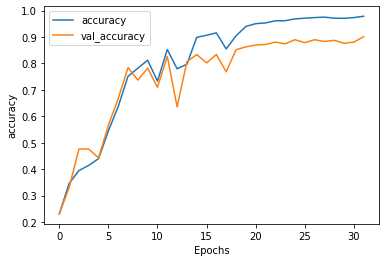

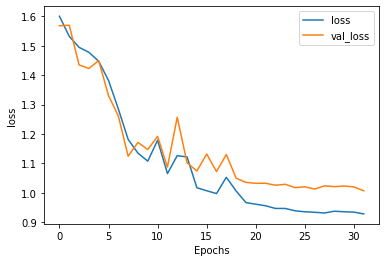

In [ ]:
model = build_model()
history = model.fit(
    train_ds, 
    epochs = num_epochs, 
    validation_data = val_ds, 
    callbacks = set_callbacks(model)
)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")